# SVM and Ensembles

In [1]:
!git init; git pull https://github.com/harshit-3/HackDay.git

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 2), reused 18 (delta 2), pack-reused 0
Unpacking objects: 100% (18/18), done.
From https://github.com/harshit-3/HackDay
 * branch            HEAD       -> FETCH_HEAD


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from IPython.core.display import Image

## Italian Olives

![](https://github.com/harshit-3/HackDay/blob/main/images/Italy.png?raw=1)

I found this data set in the RGGobi book (http://www.ggobi.org/book/), from which the above diagram is taken. It has "the percentage composition of fatty acids
found in the lipid fraction of Italian olive oils', with oils from 3 regions of Italy: the North, the South, and Sardinia. The regions themselves are subdivided into areas as shown in the map above. The source for this data is:

>Forina, M., Armanino, C., Lanteri, S. & Tiscornia, E. (1983), Classification of Olive Oils from their Fatty Acid Composition, in Martens, H. and
Russwurm Jr., H., eds, Food Research and Data Analysis, Applied Science
Publishers, London, pp. 189–214.

In [4]:
df=pd.read_csv("data/olives-cleaned.csv")
df.head(5)

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29,South
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29,South
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29,South
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35,South
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46,South


In [9]:
df['areastring'].unique()

array(['North-Apulia', 'Calabria', 'South-Apulia', 'Sicily',
       'Inland-Sardinia', 'Coast-Sardinia', 'Umbria', 'East-Liguria',
       'West-Liguria'], dtype=object)

### exploring globally

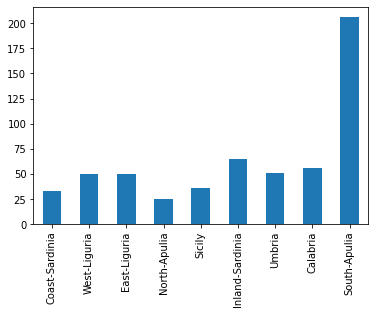

In [5]:
pd.value_counts(df.areastring, sort=False).plot(kind="bar");

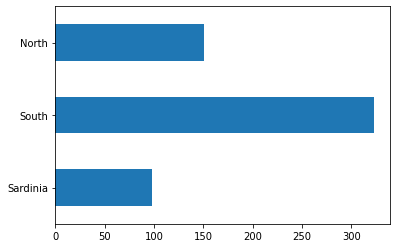

In [6]:
pd.value_counts(df.regionstring, sort=False).plot(kind="barh");

In [7]:
df.describe()

,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
count,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000
mean,1.699301,4.599650,12.317413,1.260944,2.288654,73.117483,9.805280,0.318881,0.580979,0.162815
std,0.859968,2.356687,1.685923,0.524944,0.367449,4.058102,2.427992,0.129687,0.220302,0.140833
min,1.000000,1.000000,6.100000,0.150000,1.520000,63.000000,4.480000,0.000000,0.000000,0.010000
25%,1.000000,3.000000,10.950000,0.877500,2.050000,70.000000,7.707500,0.260000,0.500000,0.020000
50%,1.000000,3.000000,12.010000,1.100000,2.230000,73.025000,10.300000,0.330000,0.610000,0.170000
75%,3.000000,7.000000,13.600000,1.692500,2.490000,76.800000,11.807500,0.402500,0.700000,0.280000
max,3.000000,9.000000,17.530000,2.800000,3.750000,84.100000,14.700000,0.740000,1.050000,0.580000


## Figuring the South of Italy by Area

In [10]:
dfsouth=df[df.regionstring=='South']
dfsouth.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29,South
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29,South
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29,South
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35,South
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46,South


In [11]:
dfnosouth=df[df.regionstring!='South']
dfnosouth.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic,regionstring
323,Inland-Sardinia,2,5,11.29,1.20,2.22,72.72,11.12,0.43,0.98,0.02,Sardinia
324,Inland-Sardinia,2,5,10.42,1.35,2.10,73.76,11.16,0.35,0.90,0.03,Sardinia
325,Inland-Sardinia,2,5,11.03,0.96,2.10,73.80,10.85,0.32,0.94,0.03,Sardinia
326,Inland-Sardinia,2,5,11.18,0.97,2.21,72.79,11.54,0.35,0.94,0.02,Sardinia
327,Inland-Sardinia,2,5,10.52,0.95,2.15,73.88,11.26,0.31,0.92,0.01,Sardinia


## SVM on training data for Regions

Diagram from Jesse Johnson's excellent Shape of Data;
http://shapeofdata.wordpress.com/2013/05/14/linear-separation-and-support-vector-machines/


![max margin](https://github.com/harshit-3/HackDay/blob/main/images/svm.png?raw=1) 

The idea is to draw a line in space between the classes. But not any line, but the line which gives the `maximum margin` rectangle between points of different classes.

from http://nlp.stanford.edu/IR-book/html/htmledition/support-vector-machines-the-linearly-separable-case-1.html :
![support vectors](https://github.com/harshit-3/HackDay/blob/main/images/img1260.png?raw=1)

The points right at the boundary are called the support vectors, which is where the name comes from.

But what if the separability is not so simple, and there are points intruding?

![intrusion](https://github.com/harshit-3/HackDay/blob/main/images/svm21.png?raw=1)

Then the idea is to minimize the distance of the "crossed over" points from the separating line. These crossed over points are costed using "slack" vectors. You dont want too many of these.

You obtain the line by minimizing the [Hinge Loss](http://en.wikipedia.org/wiki/Hinge_loss)

In [12]:
from ipywidgets import interact
import ipywidgets as widgets

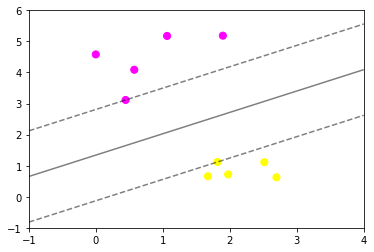

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#Stolen from Jake's notebooks, above: https://github.com/jakevdp/ESAC-stats-2014
from sklearn.datasets import make_blobs
from sklearn.svm import SVC # "Support Vector Classifier"

def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([[xi, yj]])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

def plot_svm(N):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
#interact(plot_svm, N=[10, 200]);
interact(plot_svm, N=widgets.IntSlider(min=10, max=200, step=10, value=90));

Notice how the points that mainly matter are the ones which are near the support vector. If new such points come in, the prediction can change.

## Training a SVM

We just do two acids to start and illustrate. We'll try and see if an Olive oil is from Sardinia or not!

In [ ]:
X = dfnosouth[['linoleic', 'arachidic']]
X = dfnosouth[['linolenic', 'arachidic']]


y = (dfnosouth.regionstring.values=='Sardinia')*1

### Q1: Standardize the data set the correct way

The correct way, unlike what we have done earlier is to standardize the training and test sets separately. Why is this?

You are **not supposed to have seen the test set**. If you do, you are contaminating the training set and your results and error will have an optimistic bias on the training set.

Indeed you will need to standardize the test set data to do your predictions by the mean and the standard deviation learned on the training set!

Store the standardized data in `Xtrain, Xtest, ytrain, ytest`

In [ ]:
# your code here


In [ ]:
Xtrain.shape, Xtest.shape

Now fit the SVM with a "linear" kernel.

In [ ]:
# your code here


In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='spring', alpha=0.3)
plot_svc_decision_function(clf, plt.gca())
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=100, edgecolors='k', facecolors='none')
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, marker="s", cmap='spring', alpha=0.5);

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='spring', alpha=0.3)
plot_svc_decision_function(clf, plt.gca())
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=100, edgecolors='k', facecolors='none')
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=clf.predict(Xtest), s=50, marker="s", cmap='spring', alpha=0.5);

What is our accuracy?

In [ ]:
# your code here


## The Kernel Trick

Often in SVMs one uses the [kernel trick](http://en.wikipedia.org/wiki/Kernel_method), which maps a lower dimension to a higher one to make things separable.

See (from above mentioned book)

![](https://github.com/harshit-3/HackDay/blob/main/images/img1331.png?raw=1)

So lets see what using a Radial Gaussian kernel look like?

$$e^{-\gamma d(x_1,x_2)^2}$$


### Q2: Train a radial kernel

Train a radial kernel by looking up the documentation. For simplicity we'll start by using the default hyperparameters

In [ ]:
# your code here


In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=ytrain, s=50, cmap='spring', alpha=0.3)
plot_svc_decision_function(clf, plt.gca())
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=100, facecolors='none', edgecolors='k')
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=50, marker="s", cmap='spring', alpha=0.5);

 Compute the confusion matric and the accuracy score!

In [ ]:
# your code here


In [ ]:
clf.score(Xtest, ytest)

### Q3: Use cross validation

This is a take away for home. Use cross validation to estimate the hyper-parameters of this model. These are the regularization and the kernel radius.

This page will help: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

Discuss on discourse!

## Detective work

See if you can separate out sicilian olive oils using either SVM or logistic regression or kNN.

When you do this you might learn something about how the olive oil industry works...

Discuss on discourse!